##  Импорты:

In [227]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
# For encoding categorical data
from sklearn.preprocessing import OneHotEncoder

# For scaling
from sklearn.preprocessing import MinMaxScaler

# For splitting data
from sklearn.model_selection import train_test_split

# For modelling
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures

# For evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import torch
import pytorch_tabnet
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

## Считывание данных

In [ ]:
df = pd.read_csv('./Data/Churn_Modelling.csv')
df.head()

## EDA - исследовательский анализ данных

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
# проверка на null
df.isnull().sum()

In [ ]:
# удаляем повторяющиеся значения
df.drop_duplicates(inplace=True)

In [ ]:
# Целевой стобец - 'Exited'
# Распределение по ожидаемому ответу
px.histogram(
    df,
    x='Exited',
    title='Распределение по ожидаемому ответу',
    opacity=0.7
)

In [ ]:
df['Exited'].value_counts()

In [ ]:
px.histogram(
    df,
    x='Gender',
    title='Распредение по полу и ожидаемому ответу',
    color='Exited',
    opacity=0.7,
    barmode='group',
)

In [ ]:
px.histogram(
    df,
    x='Geography',
    title='Распредение по локации клиента  и ожидаемому ответу',
    color='Exited',
    opacity=0.7,
    barmode='group',
)

In [ ]:
px.histogram(
    df,
    x='HasCrCard',
    title='Распредение по наличию кредитных карт у клиента и ожидаемому ответу',
    color='Exited',
    opacity=0.7,
    barmode='group',
)

In [ ]:
px.histogram(
    df,
    x='IsActiveMember',
    title='Распредение по активности клиента и ожидаемому ответу',
    color='Exited',
    opacity=0.7,
    barmode='group',
)

In [ ]:
df_plot1 = df.groupby('Geography').Exited.mean().reset_index()
df_plot2 = df.groupby('Gender').Exited.mean().reset_index()
df_plot3 = df.groupby('HasCrCard').Exited.mean().reset_index()
df_plot4 = df.groupby('IsActiveMember').Exited.mean().reset_index()

In [ ]:
df_plot1

In [ ]:
fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=("Geography", "Gender", "Has credit card", "Is active member")
)

fig.add_trace(
    go.Bar(x=df_plot1["Geography"], y=df_plot1["Exited"], showlegend=False),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df_plot2["Gender"], y=df_plot2["Exited"], showlegend=False),
    row=1, col=2

)

fig.add_trace(
    go.Bar(x=df_plot3['HasCrCard'], y=df_plot3['Exited'], showlegend=False),
    row=2, col=1

)

fig.add_trace(
    go.Bar(x=df_plot4['IsActiveMember'], y=df_plot4['Exited'], showlegend=False),
    row=2, col=2
)

fig.update_layout(height=500, width=1000,
                  title_text="Средняя скорость оттока клиентов")

### Выводы
- География
        Доля клиентов, привлеченных в той или иной стране, обратно пропорциональна количеству клиентов в этой стране.
        В Германии самый высокий уровень оттока
- Пол
    Несмотря на то, что мужчины составляют большую долю клиентов, женщины, по-видимому, имеют более высокий процент оттока, чем мужчины.
- Наличие Кредитной карты
    Удивительно, но все больше клиентов, владеющих кредитной картой, похоже, покинули банк. Хотя доля покинувших банк в обеих категориях почти одинакова.

- Активность клиента
    Количество неактивных участников увеличилось по сравнению с активными, что здесь кажется очевидным.
    Хотя количество неактивных участников почти такое же, как и активных, что не является хорошей новостью для банка.
    Неактивные участники имеют почти двойную скорость оттока.

In [ ]:
# Aesthetics
sns.set_style('ticks')
sns.set_palette('Set2')
mpl_color = sns.color_palette('Set2')

# Plot features universal settings
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=13)
plt.rc('font', size=13)

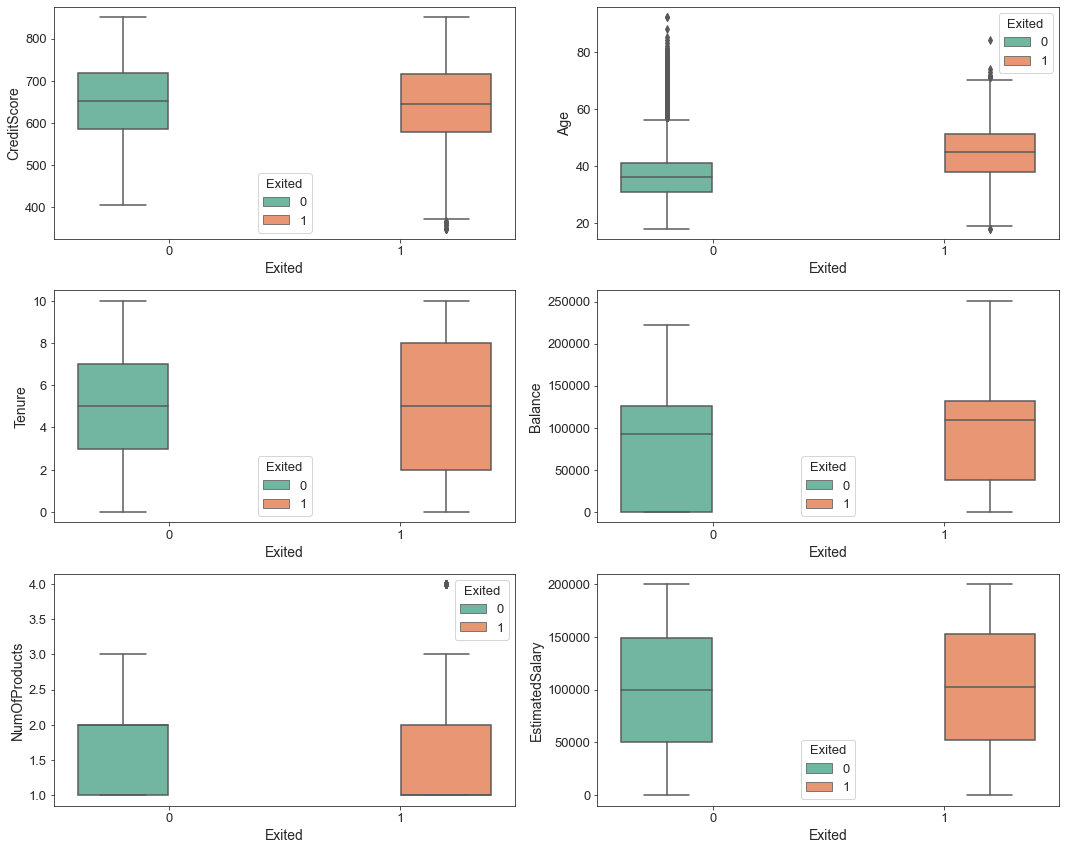

In [ ]:
# Relations based on the continuous data attributes
fig, ax = plt.subplots(3, 2, figsize=(15, 12), tight_layout=True)
sns.boxplot(y='CreditScore', x='Exited', hue='Exited', data=df, ax=ax[0][0])
sns.boxplot(y='Age', x='Exited', hue='Exited', data=df, ax=ax[0][1])
sns.boxplot(y='Tenure', x='Exited', hue='Exited', data=df, ax=ax[1][0])
sns.boxplot(y='Balance', x='Exited', hue='Exited', data=df, ax=ax[1][1])
sns.boxplot(y='NumOfProducts', x='Exited', hue='Exited', data=df, ax=ax[2][0])
sns.boxplot(y='EstimatedSalary', x='Exited', hue='Exited', data=df, ax=ax[2][1])

## Выводы
- Кредитный рейтинг, по-видимому, не оказывает никакого влияния на скорость оттока, поэтому для дальнейшего анализа может быть создана специальная функция, учитывающая возраст.
- Люди старшего возраста склонны к оттоку больше, чем молодые.
- Люди с очень низкими и очень высокими сроками пребывания в должности, по-видимому, демонстрируют статус оттока, который довольно неоднозначен, поэтому может быть разработана новая функция в отношении возраста.
- Сбитые клиенты имели более высокий средний баланс. Баланс по отношению к заработной плате мог бы быть лучшим показателем для измерения его влияния на уровень оттока.
- Количество продуктов и предполагаемая зарплата, по-

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

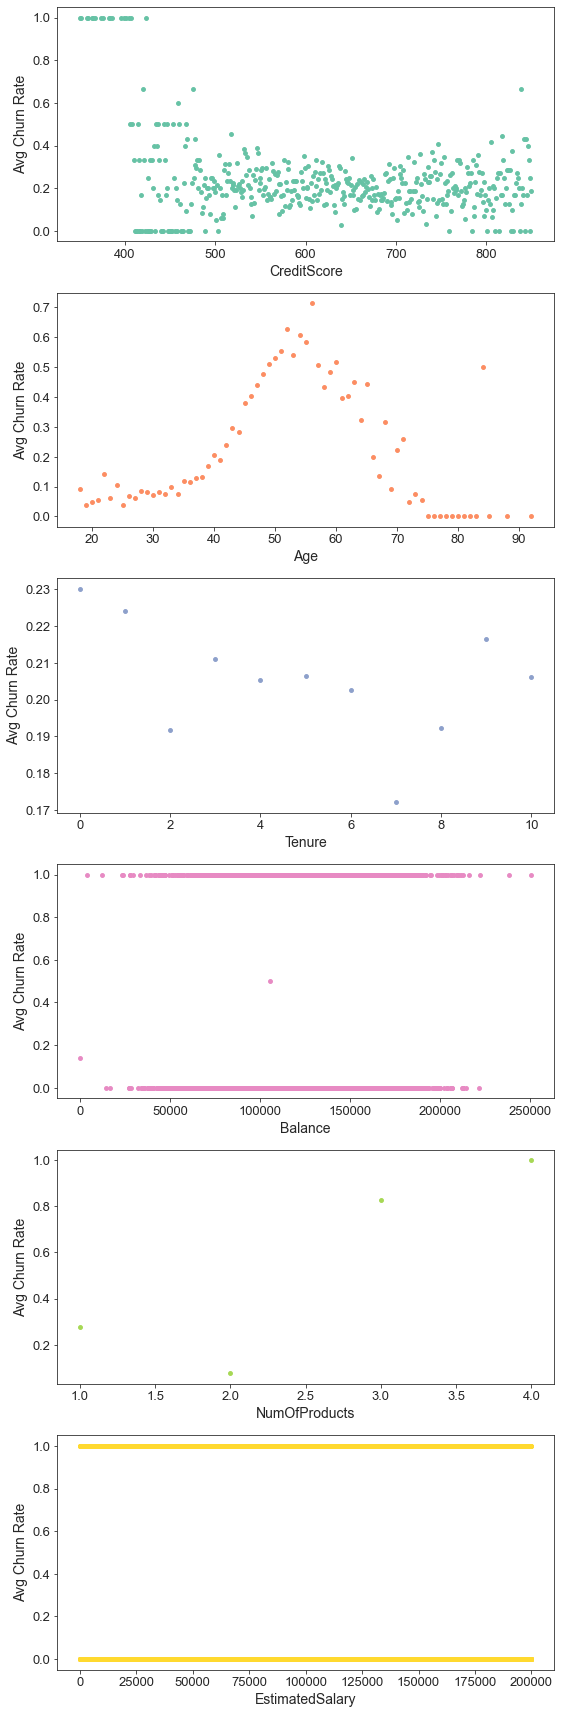

In [ ]:
continuous_variables = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
fig, ax = plt.subplots(6, figsize=(8, 24), tight_layout=True)
for item in continuous_variables:
    df_plot = df.groupby(item).Exited.mean().reset_index()
    ax[continuous_variables.index(item)].scatter(x=df_plot[item], y=df_plot.Exited, s=15,
                                                 c=mpl_color[continuous_variables.index(item)])
    ax[continuous_variables.index(item)].set_xlabel(item)
    ax[continuous_variables.index(item)].set_ylabel("Avg Churn Rate")
plt.show()

## Выводы
Вопреки выводам из предыдущих графиков в виде ящиков с усами, из приведенных выше точечных графиков у нас есть следующие выводы:

Очень низкий кредитный рейтинг, похоже, действительно имеет очень высокий уровень оттока.
В возрасте от 50 до 60 лет также наблюдается более высокий уровень оттока, чем в других возрастных группах.

## Работа с категориальными признаками
#### Применяю one hot encoding
Цель состоит в том, чтобы закодировать все категориальные признаки только в 1 и 0.
Таким образом, столбец географии разделен на его уникальные значения, и то же самое относится к столбцу пола.

In [ ]:
ohe1 = OneHotEncoder()
geo_transformed = ohe1.fit_transform(df[["Geography"]]).toarray()
geo_categories = ohe1.categories_[0]
df[geo_categories] = geo_transformed

In [ ]:
ohe2 = OneHotEncoder()
gender_transformed = ohe2.fit_transform(df[["Gender"]]).toarray()
gender_categories = ohe2.categories_[0]
df[gender_categories] = gender_transformed

In [ ]:

df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0,1.0,0.0
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0,1.0,0.0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0,1.0,0.0
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0,1.0,0.0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,1.0,0.0,0.0,0.0,1.0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,1.0,0.0,0.0,0.0,1.0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1.0,0.0,0.0,1.0,0.0
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,0.0,1.0,0.0,0.0,1.0


In [ ]:
df = df.drop(["Geography", "Gender"], axis=1)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male
0,1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0,1.0,0.0
1,2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0,1.0,0.0
2,3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0,1.0,0.0
3,4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0,1.0,0.0
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0,1.0,0.0


## Проверка корреляции

In [ ]:
df.corr()

/var/folders/_1/3jjnk10x1kq7j94b1068smjm0000gn/T/ipykernel_25409/1886530979.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.006495,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571,0.008590,-0.000044,-0.009905,-0.018196,0.018196
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.014883,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248,-0.004049,-0.003097,0.007800,0.002641,-0.002641
CreditScore,0.005840,0.005308,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,-0.008928,0.005538,0.004780,0.002857,-0.002857
Age,0.000783,0.009497,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,-0.039208,0.046897,-0.001685,0.027544,-0.027544
Tenure,-0.006495,-0.014883,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001,-0.002848,-0.000567,0.003868,-0.014733,0.014733
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,-0.231329,0.401110,-0.134892,-0.012087,0.012087
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,0.001230,-0.010419,0.009039,0.021859,-0.021859
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.002467,0.010577,-0.013480,-0.005766,0.005766
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,0.003317,-0.020486,0.016732,-0.022544,0.022544
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,-0.003332,0.010297,-0.006482,0.008112,-0.008112


/var/folders/_1/3jjnk10x1kq7j94b1068smjm0000gn/T/ipykernel_25409/2861114682.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot:>

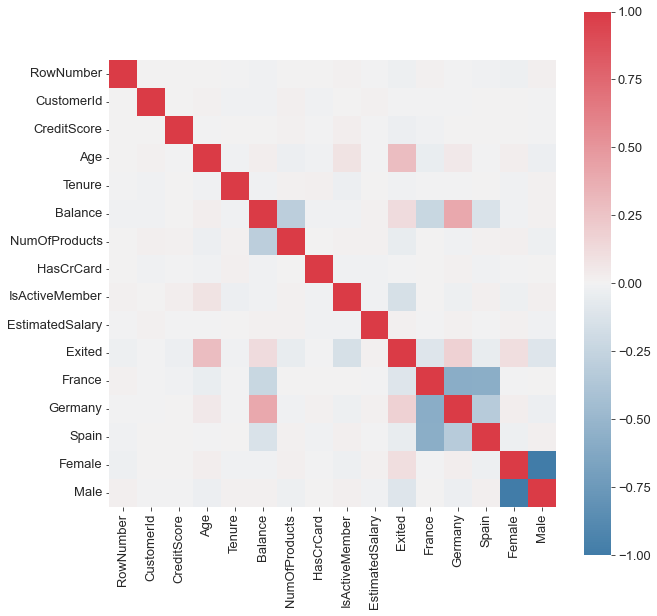

In [ ]:
plt.figure(figsize=(10, 10))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(df.corr(), cmap=cmap, center=0, annot=False, square=True)

Мы можем легко игнорировать корреляцию между мужчиной и женщиной и Францией - Германией - Испанией, поскольку эти признаки были получены от одного и того же родительского признака.
"NumOfProducts" и "Germany" слабо коррелируют с "Balance" с коэффициентом <-0.3 и >0.3 соответственно.

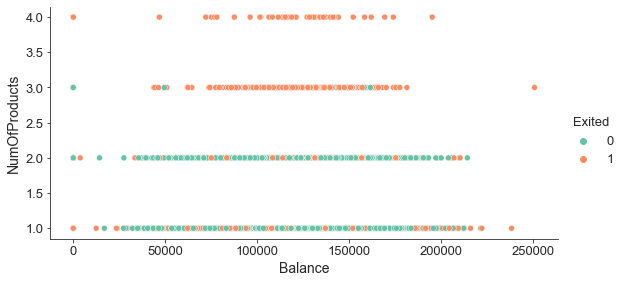

In [ ]:
sns.pairplot(df, x_vars=["Balance"], y_vars=["NumOfProducts"], hue="Exited", height=4, aspect=2)

Похоже, что отток сильно зависит от количества продуктов, принадлежащих клиенту. Большее количество продуктов, как правило, имеет более высокую вероятность оттока, и наоборот.

## Feature engineering

#### Создадим три следующих соотношения:
- Соотношение баланса и заработной платы
- Соотношение срока пребывания и возраста
- Соотношение кредитного балла и возраста

In [ ]:
df['BalanceSalaryRatio'] = df.Balance / df.EstimatedSalary
df['TenureByAge'] = df.Tenure / df.Age
df['CreditScoreGivenAge'] = df.CreditScore / df.Age
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
0,1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0,1.0,0.0,0.000000,0.047619,14.738095
1,2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0,1.0,0.0,0.744677,0.024390,14.829268
2,3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0,1.0,0.0,1.401375,0.190476,11.952381
3,4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0,1.0,0.0,0.000000,0.025641,17.923077
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0,1.0,0.0,1.587055,0.046512,19.767442


#### Зависимость созданных соотношений и оттока

(-1.0, 5.0)

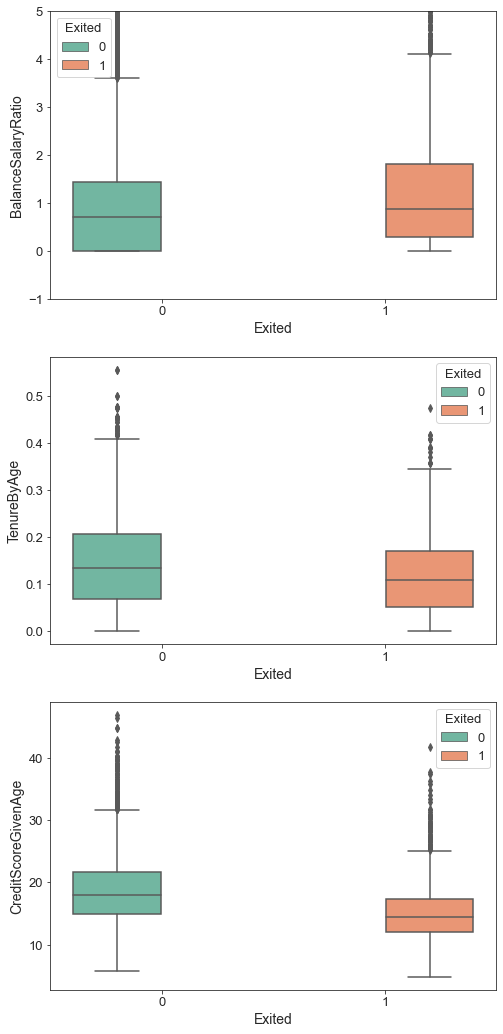

In [ ]:
fig, ax = plt.subplots(3, figsize=(8, 18))
sns.boxplot(y='BalanceSalaryRatio', x='Exited', hue='Exited', data=df, ax=ax[0])
sns.boxplot(y='TenureByAge', x='Exited', hue='Exited', data=df, ax=ax[1])
sns.boxplot(y='CreditScoreGivenAge', x='Exited', hue='Exited', data=df, ax=ax[2])
ax[0].set_ylim(-1, 5)

Высокий показатель balance/salary приводит к оттоку
Низкий показатель credit-score/age приводит к оттоку

In [ ]:
to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'BalanceSalaryRatio',
            'TenureByAge', 'CreditScoreGivenAge']
scaler = MinMaxScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
0,1,15634602,Hargrave,0.538,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,1.0,0.0,0.0,1.0,0.0,0.000000,0.085714,0.235083
1,2,15647311,Hill,0.516,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0.0,0.0,1.0,1.0,0.0,0.000070,0.043902,0.237252
2,3,15619304,Onio,0.304,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,1.0,0.0,0.0,1.0,0.0,0.000132,0.342857,0.168807
3,4,15701354,Boni,0.698,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,1.0,0.0,0.0,1.0,0.0,0.000000,0.046154,0.310859
4,5,15737888,Mitchell,1.000,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,0.0,0.0,1.0,1.0,0.0,0.000150,0.083721,0.354739


## Train Test Split
Splitting the data into train set (80%) and test set (20%).

In [ ]:
y = df.Exited
X = df.loc[:, df.columns != 'Exited']
X = X.loc[:, X.columns != 'Surname']

In [ ]:
X.columns

Index(['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'France', 'Germany', 'Spain', 'Female', 'Male', 'BalanceSalaryRatio',
       'TenureByAge', 'CreditScoreGivenAge'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

## Построение моделей: подбор параметров

In [ ]:
# X_train = torch.tensor(X_train.values)
# X_test = torch.tensor(X_test.values)
#
# y_train = torch.tensor(y_train.values)
# y_test = torch.tensor(y_test.values)

#### Logistic Regression - Hyperparameter tuning

In [ ]:
param_grid = {'C': [0.5, 1, 10, 100, 500], 'max_iter': [100, 250, 300, 500]}
lr_grid = GridSearchCV(LogisticRegression(), param_grid, cv=10)
lr_grid.fit(X_train, y_train)
print(lr_grid.best_score_)
print(lr_grid.best_params_)
print(lr_grid.best_estimator_)

0.7947500000000001
{'C': 0.5, 'max_iter': 100}
LogisticRegression(C=0.5)


## XGB Classifier - Hyperparameter tuning

In [ ]:
param_grid = {'max_depth': [5, 7], 'gamma': [0.01, 0.001], 'learning_rate': [0.1, 0.3], 'n_estimators': [10, 20],
              'min_child_weight': [1, 10]}
xgb_grid = GridSearchCV(XGBClassifier(), param_grid, cv=5)
xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_)

0.8632500000000001
{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 10}
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.01, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)


## Построение моделей с лучшими найденными гиперпараметрами

In [ ]:
lr_model = LogisticRegression(C=0.0001, max_iter=100, class_weight={0: 0.2, 1: 0.8})
lr_model.fit(X_train, y_train)
lr_predict = lr_model.predict(X_test)
print(classification_report(y_test, lr_predict))

              precision    recall  f1-score   support

           0       0.82      0.30      0.44      1605
           1       0.20      0.73      0.32       395

    accuracy                           0.38      2000
   macro avg       0.51      0.51      0.38      2000
weighted avg       0.70      0.38      0.41      2000



In [ ]:
xgb_model = XGBClassifier(gamma=0.01, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=10)
xgb_model.fit(X_train, y_train)
xgb_predict = xgb_model.predict(X_test)
print(classification_report(y_test, xgb_predict))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1605
           1       0.77      0.43      0.55       395

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.85      2000



In [224]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=3)

x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.7, random_state=8)

In [242]:
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

clf1_nopreproc = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                                  optimizer_params=dict(lr=2e-2),
                                  scheduler_params={"step_size": 10,  # how to use learning rate scheduler
                                                    "gamma": 0.9},
                                  scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                  mask_type='entmax'  # "sparsemax"
                                  )

# fit the model
clf1_nopreproc.fit(
    x_train.values, y_train.values,
    eval_set=[(x_train.values, y_train.values), (x_val.values, y_val.values)],
    eval_name=['train', 'valid'],
    eval_metric=['auc', 'accuracy'],
    max_epochs=40,# patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning:

Device used : cpu



epoch 0  | loss: 0.64702 | train_auc: 0.63395 | train_accuracy: 0.61929 | valid_auc: 0.61114 | valid_accuracy: 0.61444 |  0:00:01s
epoch 1  | loss: 0.5486  | train_auc: 0.66439 | train_accuracy: 0.738   | valid_auc: 0.65607 | valid_accuracy: 0.75    |  0:00:01s
epoch 2  | loss: 0.51213 | train_auc: 0.73139 | train_accuracy: 0.727   | valid_auc: 0.71778 | valid_accuracy: 0.71444 |  0:00:02s
epoch 3  | loss: 0.48541 | train_auc: 0.75035 | train_accuracy: 0.68729 | valid_auc: 0.73677 | valid_accuracy: 0.67222 |  0:00:03s
epoch 4  | loss: 0.47894 | train_auc: 0.76757 | train_accuracy: 0.69429 | valid_auc: 0.74802 | valid_accuracy: 0.68    |  0:00:04s
epoch 5  | loss: 0.47817 | train_auc: 0.79657 | train_accuracy: 0.76929 | valid_auc: 0.78267 | valid_accuracy: 0.76556 |  0:00:05s
epoch 6  | loss: 0.45953 | train_auc: 0.81273 | train_accuracy: 0.80414 | valid_auc: 0.79648 | valid_accuracy: 0.80444 |  0:00:06s
epoch 7  | loss: 0.4663  | train_auc: 0.8283  | train_accuracy: 0.763   | valid_auc

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



In [240]:
tabnet_pred = clf1_nopreproc.predict(x_test.values)
print(classification_report(y_test.values, tabnet_pred))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1659
           1       0.54      0.69      0.60       441

    accuracy                           0.81      2100
   macro avg       0.72      0.76      0.74      2100
weighted avg       0.83      0.81      0.82      2100

